## Mercedes-Benz Greener Manufacturing
### Can you cut the time a Mercedes-Benz spends on the test bench?

This dataset contains an anonymized set of variables, each representing a custom feature in a Mercedes car. For example, a variable could be 4WD, added air suspension, or a head-up display.

The ground truth is labeled ‘y’ and represents the time (in seconds) that the car took to pass testing for each variable.

**File descriptions**
- Variables with letters are categorical. 
- Variables with 0/1 are binary values.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder

In [2]:
df_train = pd.read_csv('M6W4/train.csv')
#df_test = pd.read_csv('M6W4/test.csv')

### 1.Data Cleaning & EDA

In [3]:
df_train.shape

(4209, 378)

In [4]:
df_train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# check for null values
print ('Number of null values :', df_train.isna().sum().sum())

Number of null values : 0


In [6]:
df_train.describe()

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,4205.960798,100.669318,0.013305,0.0,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,...,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,2437.608688,12.679381,0.114590,0.0,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,...,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,72.110000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2095.000000,90.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4220.000000,99.150000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6314.000000,109.010000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8417.000000,265.320000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

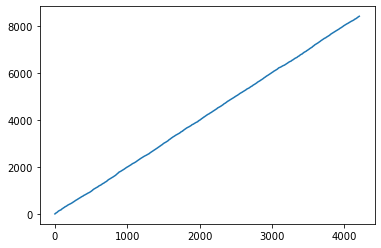

In [7]:
# ID is not in sequence - could be a timestamp
df_train['ID'].plot()

In [8]:
# ID is cleary not increasing by 1 - we will examine ID relationship with y & categorical features later
y_inc = df_train['ID'] - df_train['ID'].shift(1)
y_inc.value_counts()

1.0     2108
2.0     1050
3.0      511
4.0      283
5.0      124
6.0       67
7.0       28
8.0       21
9.0        9
10.0       4
12.0       1
11.0       1
14.0       1
Name: ID, dtype: int64

In [9]:
# some of the features have exactly the same values. It is safe to drop the one of them 
cols = df_train.columns.tolist()
for col1 in cols:
    for col2 in cols:
        if (col1 != col2) and df_train[col1].equals(df_train[col2]):
            df_train.drop(col2,axis=1,inplace=True)
            #print (col1, "matching",  col2 " - to be removed")
            cols.remove(col2)
print ("dataset size after removing features with matching values : ", df_train.shape)

dataset size after removing features with matching values :  (4209, 322)


In [10]:
# check for duplicate rows
print ('number of duplicates:', df_train.duplicated().sum())
print ('number of duplicates (excluding ID):', df_train.iloc[:,1:].duplicated().sum())
print ('number of duplicates (excluding ID & y):', df_train.iloc[:,2:].duplicated().sum())
print (f'percentage of duplicates (excluding ID & y) :{df_train.iloc[:,2:].duplicated().sum()/df_train.shape[0]*100:2.2f}')

number of duplicates: 0
number of duplicates (excluding ID): 1
number of duplicates (excluding ID & y): 298
percentage of duplicates (excluding ID & y) :7.08


In [11]:
# Having the same set of features with different result "y" will confuse the model and decrease the accuracy 
# therefore, we will drop the duplicates (excluding ID & y)
df_train = df_train.drop_duplicates(subset=df_train.columns[2:], keep='last')
print ("dataset size after removing duplicates : ",  df_train.shape)

dataset size after removing duplicates :  (3911, 322)


In [12]:
# check the numeric and non-numeric columns
num_col = []
cat_col = []
for col in df_train.columns:
    if (df_train[col].dtype==object):
        cat_col.append(col)
    elif (df_train[col].dtype==float or df_train[col].dtype=='int64'):
        num_col.append(col)
        
print ('Count of numeric features :', len(num_col))
print ('count of non-numeric features :', len(cat_col))

Count of numeric features : 314
count of non-numeric features : 8


<AxesSubplot:xlabel='y'>

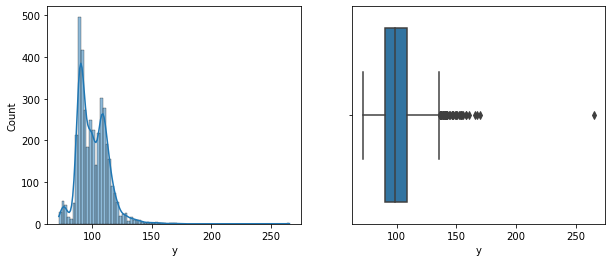

In [13]:
# Trying to understand 'y' - there one clear outlier
fig,axes = plt.subplots (nrows=1, ncols=2, figsize=(10,4))
sns.histplot(x=df_train['y'], kde=True, ax=axes[0])
sns.boxplot(x=df_train['y'], ax=axes[1])

In [14]:
# drop the outlier
df_train.drop(df_train.loc[df_train['y'] > 250].index, inplace=True)
print ("dataset size after dropping y outlier: ", df_train.shape)

dataset size after dropping y outlier:  (3910, 322)


<AxesSubplot:xlabel='y'>

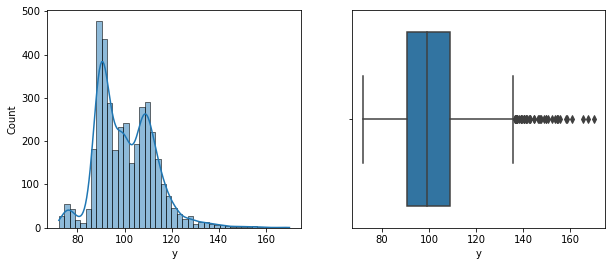

In [15]:
fig,axes = plt.subplots (nrows=1, ncols=2, figsize=(10,4))
sns.histplot(x=df_train['y'], kde=True, ax=axes[0])
sns.boxplot(x=df_train['y'], ax=axes[1])

<AxesSubplot:xlabel='ID', ylabel='y'>

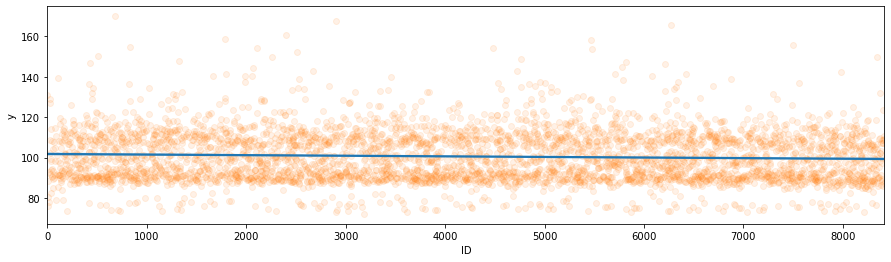

In [16]:
# we plot ID & y regression - insterestingly, y is slightly dropping   
plt.figure(figsize=(15,4))
sns.regplot(x='ID',y='y',data=df_train,scatter_kws={'color':'C1', 'alpha':0.1}, line_kws={'color':'C0'})

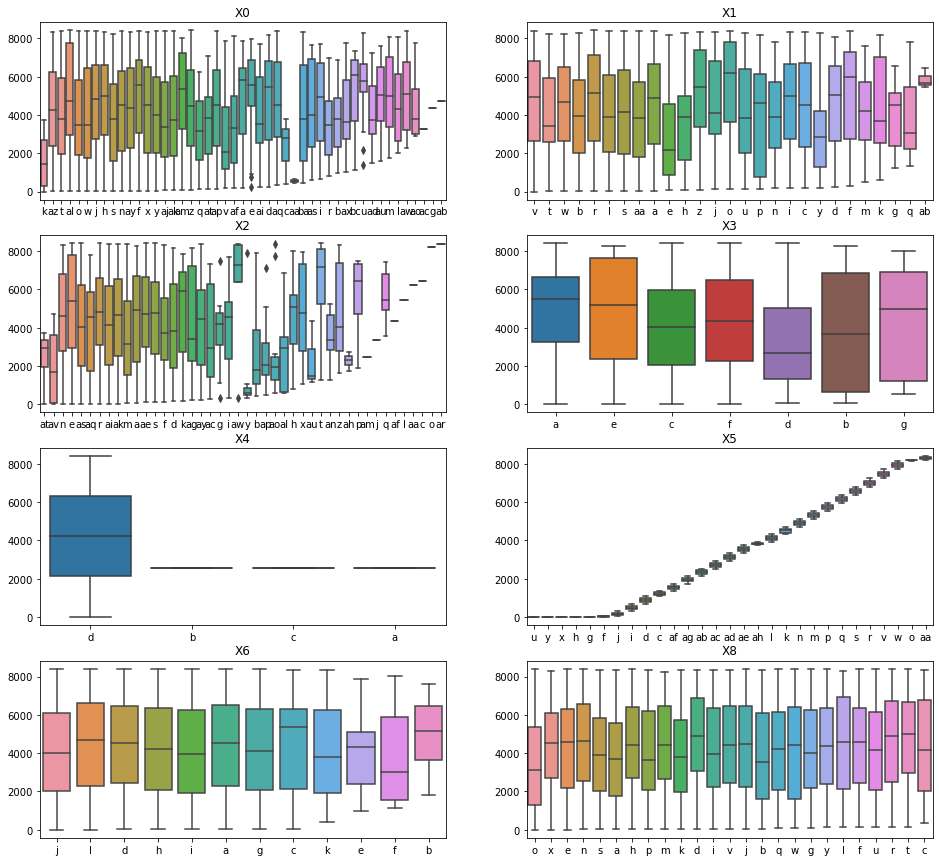

In [17]:
# Visualizing categorical variables by ID to see if there is a trend
fig, axes = plt.subplots(nrows=len(cat_col)//2, ncols=2, figsize=(16,15))
for n, col in enumerate(cat_col):
    sns.boxplot(x=df_train[col], y=df_train['ID'],ax=axes[n//2, n%2])
    axes[n//2, n%2].set_title(col)
    axes[n//2, n%2].set_xlabel('')
    axes[n//2, n%2].set_ylabel('')

From the visualization above, it seems that X5 is some sort of grouping by ID and X4 have very minimum variance


In [18]:
# Visualizing categorical variables by y
#fig, axes = plt.subplots(nrows=len(cat_col)//2, ncols=2, figsize=(16,15))
#for n, col in enumerate(cat_col):
#    sns.boxplot(x=df_train[col], y=df_train['y'],ax=axes[n//2, n%2])
#    axes[n//2, n%2].set_title(col)
#    axes[n//2, n%2].set_xlabel('')
#    axes[n//2, n%2].set_ylabel('')

In [19]:
# examining the values of X4
df_train['X4'].value_counts()

d    3906
a       2
b       1
c       1
Name: X4, dtype: int64

In [20]:
# It's fair to drop X4 since the variance is very minimum 
df_train.drop('X4',axis=1,inplace=True)
df_train.shape

(3910, 321)

In [21]:
# now let's check X5
df_train['X5'].nunique()

29

In [22]:
# for X5 - we define the range of IDs per X5 category and check for overlaps 
df_X5 = df_train.groupby('X5').agg({'ID':['count','min','max'], 'y':'mean'}).sort_values(('ID','min'))
df_X5['overlap'] = df_X5[('ID','min')].shift(-1) - df_X5[('ID','max')]
df_X5

ID                       y overlap
   count   min   max        mean        
X5                                      
u      1     0     0  130.810000     6.0
y      1     6     6   88.530000     1.0
x      2     7     9   78.440000     4.0
h      1    13    13   78.020000     5.0
g      1    18    18   92.930000     6.0
f      7    24    34  105.594286     3.0
j    107    37   295   99.959252     5.0
i    195   300   684  101.175692     2.0
d    192   686  1090  101.100938     2.0
c    118  1092  1342  102.546610     2.0
af   165  1344  1746  101.061333     2.0
ag   188  1748  2152  102.313989     1.0
ab   185  2153  2528  101.955892     3.0
ac   194  2531  2940   99.985515     4.0
ad   175  2944  3336  100.942229     6.0
ae   194  3342  3738  100.798196     2.0
ah    94  3740  3915   99.281064   -10.0
l    182  3905  4317   99.534560     2.0
k    163  4319  4687  100.170798     4.0
n    196  4691  5106  102.591684     4.0
m    193  5110  5513  101.951347     1.0
p    200  5514  5948  100.598350     1.0
q    201  5949  6362  100.455970     3.0
s    203  6365  6783  100.248571     2.0
r    205  6785  7238   98.380146     3.0
v    212  7241  7714   99.477217     2.0
w    211  7716  8164   98.597725     1.0
o     19  8165  8200   96.588947     3.0
aa   105  8203  8417   98.429238     NaN

It's clear that X5 is grouping by ID with one overlap 

In [23]:
cat_col.remove('X4')
cat_col

['X0', 'X1', 'X2', 'X3', 'X5', 'X6', 'X8']

In [24]:
# count of unique values in non-numeric columns
for col in cat_col:
    print (col, ':',df_train[col].nunique())

X0 : 47
X1 : 27
X2 : 44
X3 : 7
X5 : 29
X6 : 12
X8 : 25


In [25]:
# Use one-hot encoding for categorical features - i didn't use 'get_dummies' since we already have too many columns
for col in cat_col:
    df_train[col] = LabelEncoder().fit_transform(df_train[col])
#    df_train = pd.get_dummies(df_train, columns=[col], prefix=[col] )

In [26]:
# count of unique values in non-numeric columns
for col in cat_col:
    print (col, ':',df_train[col].nunique())

X0 : 47
X1 : 27
X2 : 44
X3 : 7
X5 : 29
X6 : 12
X8 : 25


In [27]:
# we remove ID & y from the numeric columns before we examine them
num_col.remove('ID')
num_col.remove('y')

In [28]:
# check the columns with fixed value - to be removed
for col in num_col:
    if (df_train[col].nunique()==1):
        print (col, ":", df_train[col].nunique())
        df_train.drop(col,axis=1,inplace=True)
        num_col.remove(col)
print ("dataset size after removing numeric features with fixed value : ", df_train.shape)

X290 : 1
dataset size after removing numeric features with fixed value :  (3910, 320)


In [29]:
# some of the features have exactly the opposite values. it is safe to drop the one of them 
for col1 in num_col:
    for col2 in num_col:
        if (col1 != col2) and ((df_train[col1] == df_train[col2]).sum()==0):
            df_train.drop(col2,axis=1,inplace=True)
            num_col.remove(col2)
            print (col1 , "exact opposite of" , col2 , "-",col2,"to be removed")     
print ("dataset size after removing oppsite features :", df_train.shape)

X29 exact opposite of X263 - X263 to be removed
X52 exact opposite of X120 - X120 to be removed
X54 exact opposite of X136 - X136 to be removed
X128 exact opposite of X130 - X130 to be removed
X142 exact opposite of X158 - X158 to be removed
X156 exact opposite of X157 - X157 to be removed
X186 exact opposite of X194 - X194 to be removed
X204 exact opposite of X205 - X205 to be removed
dataset size after removing oppsite features : (3910, 312)


In [30]:
df_train.head()

,ID,y,X0,X1,X2,X3,X5,X6,X8,X10,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
0,0,130.81,32,23,17,0,24,9,14,0,...,0,0,0,0,1,0,0,0,0,0
1,6,88.53,32,21,19,4,28,11,14,0,...,0,0,1,0,0,0,0,0,0,0
2,7,76.26,20,24,34,2,27,9,23,0,...,0,0,0,0,0,0,0,0,0,0
3,9,80.62,20,21,34,5,27,11,4,0,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,20,23,34,5,12,3,13,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_train.describe()

,ID,y,X0,X1,X2,X3,X5,X6,X8,X10,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
count,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,...,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000
mean,4229.162660,100.528240,29.584910,11.067008,16.939642,2.947315,13.325320,6.769821,11.629923,0.013811,...,0.020205,0.224297,0.336829,0.049872,0.307417,0.021739,0.006905,0.008440,0.001790,0.000512
std,2424.217631,12.445538,13.786381,8.564331,10.794622,1.746769,8.271861,2.940392,7.073518,0.116720,...,0.140718,0.417172,0.472686,0.217709,0.461483,0.145849,0.082822,0.091492,0.042279,0.022614
min,0.000000,72.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2152.250000,90.772500,19.000000,3.000000,8.000000,2.000000,5.000000,6.000000,5.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4229.500000,98.975000,34.000000,13.000000,16.000000,2.000000,15.000000,7.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6321.750000,108.967500,43.000000,20.000000,21.000000,5.000000,21.000000,9.000000,18.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8417.000000,169.910000,46.000000,26.000000,43.000000,6.000000,28.000000,11.000000,24.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# remove ID before modeling the data
df_train = df_train.drop('ID',axis=1)

In [33]:
# Create X & y for modeling
y = df_train['y']
X = df_train.drop('y',axis=1)
print (X.shape)

(3910, 310)


### 2. Data Scaling & PCA Dimentionality Reduction 

In [34]:
# normalize / scale the data
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled, columns=X.columns)
df_scaled.describe()

,X0,X1,X2,X3,X5,X6,X8,X10,X12,X13,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
count,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,...,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03,3.910000e+03
mean,5.962835e-17,2.299951e-17,-3.504443e-16,4.475533e-16,3.570205e-15,3.685600e-17,4.213736e-17,3.863065e-17,2.613510e-15,-1.144112e-15,...,6.786132e-16,-7.564282e-17,4.230773e-16,-1.082567e-15,7.957829e-16,-8.529125e-16,5.027734e-16,2.312799e-16,9.381881e-17,-1.703010e-16
std,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,...,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00
min,-2.146226e+00,-1.292386e+00,-1.569468e+00,-1.687511e+00,-1.611128e+00,-2.302648e+00,-1.644360e+00,-1.183391e-01,-2.840908e-01,-2.400298e-01,...,-1.436010e-01,-5.377292e-01,-7.126752e-01,-2.291068e-01,-6.662357e-01,-1.490712e-01,-8.338697e-02,-9.225907e-02,-4.234964e-02,-2.262235e-02
25%,-7.678784e-01,-9.420513e-01,-8.282630e-01,-5.423933e-01,-1.006591e+00,-2.618425e-01,-9.374078e-01,-1.183391e-01,-2.840908e-01,-2.400298e-01,...,-1.436010e-01,-5.377292e-01,-7.126752e-01,-2.291068e-01,-6.662357e-01,-1.490712e-01,-8.338697e-02,-9.225907e-02,-4.234964e-02,-2.262235e-02
50%,3.202910e-01,2.257315e-01,-8.705837e-02,-5.423933e-01,2.024810e-01,7.829177e-02,5.232531e-02,-1.183391e-01,-2.840908e-01,-2.400298e-01,...,-1.436010e-01,-5.377292e-01,-7.126752e-01,-2.291068e-01,-6.662357e-01,-1.490712e-01,-8.338697e-02,-9.225907e-02,-4.234964e-02,-2.262235e-02
75%,9.731927e-01,1.043179e+00,3.761945e-01,1.175283e+00,9.279244e-01,7.585602e-01,9.006680e-01,-1.183391e-01,-2.840908e-01,-2.400298e-01,...,-1.436010e-01,-5.377292e-01,1.403164e+00,-2.291068e-01,1.500970e+00,-1.490712e-01,-8.338697e-02,-9.225907e-02,-4.234964e-02,-2.262235e-02
max,1.190827e+00,1.743849e+00,2.414507e+00,1.747842e+00,1.774275e+00,1.438829e+00,1.749011e+00,8.450290e+00,3.520002e+00,4.166150e+00,...,6.963740e+00,1.859672e+00,1.403164e+00,4.364777e+00,1.500970e+00,6.708204e+00,1.199228e+01,1.083904e+01,2.361295e+01,4.420407e+01


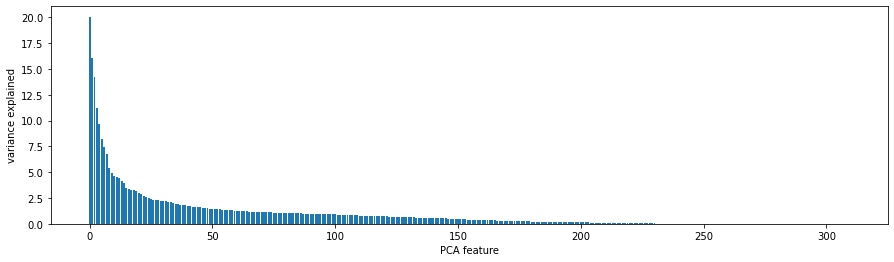

In [35]:
pca = PCA()
pca.fit_transform(df_scaled)
features = range(pca.n_components_)
plt.figure(figsize=(15,4))
plt.bar(features, pca.explained_variance_)
plt.ylabel('variance explained')
plt.xlabel('PCA feature')
plt.show()

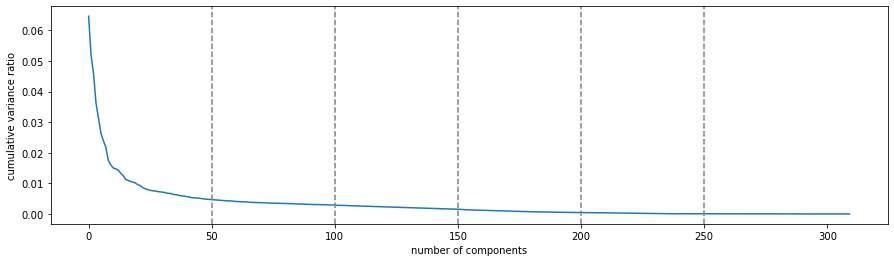

In [36]:
# We also plot the explained variance ratio.
plt.figure(figsize=(15,4))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative variance ratio')
plt.axvline(50, linestyle='--', color='gray')
plt.axvline(100, linestyle='--', color='gray')
plt.axvline(150, linestyle='--', color='gray')
plt.axvline(200, linestyle='--', color='gray')
plt.axvline(250, linestyle='--', color='gray')
plt.show()

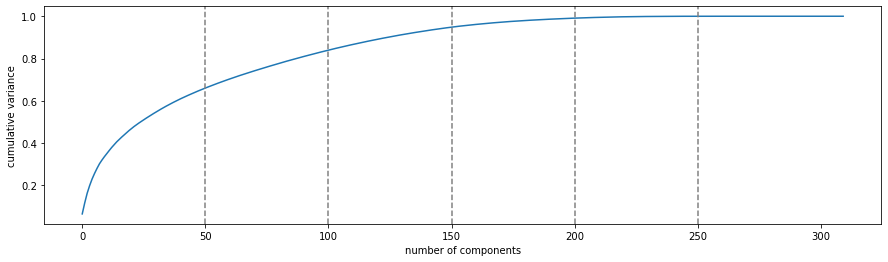

In [37]:
# We also plot the cumultive explained variance ratio.
plt.figure(figsize=(15,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative variance')
#plt.ylim([0,1.1])
plt.axvline(50, linestyle='--', color='gray')
plt.axvline(100, linestyle='--', color='gray')
plt.axvline(150, linestyle='--', color='gray')
plt.axvline(200, linestyle='--', color='gray')
plt.axvline(250, linestyle='--', color='gray')
plt.show()

In [38]:
print ("Number of components with explained variance ratio >= 0.01 :", (pca.explained_variance_ratio_>=0.01).sum())
print (f"Total explained variance retained : {pca.explained_variance_ratio_[:np.sum(pca.explained_variance_ratio_>=.01)].sum():2.4f}")

Number of components with explained variance ratio >= 0.01 : 20
Total explained variance retained : 0.4591


In [39]:
print ("Number of components with explained variance ratio >= 0.005 :", (pca.explained_variance_ratio_>=0.005).sum())
print (f"Total explained variance retained : {pca.explained_variance_ratio_[:np.sum(pca.explained_variance_ratio_>=.005)].sum():2.4f}")

Number of components with explained variance ratio >= 0.005 : 46
Total explained variance retained : 0.6362


In [40]:
print ("Number of components with explained variance ratio >= 0.001 :", (pca.explained_variance_ratio_>=0.001).sum())
print (f"Total explained variance retained : {pca.explained_variance_ratio_[:np.sum(pca.explained_variance_ratio_>=.001)].sum():2.4f}")

Number of components with explained variance ratio >= 0.001 : 168
Total explained variance retained : 0.9689


In [41]:
print(f"Number of components to retain ~50% explained variance:  {(np.cumsum(pca.explained_variance_ratio_)<0.5).sum()}")
print(f"Number of components to retain ~60% explained variance:  {(np.cumsum(pca.explained_variance_ratio_)<0.6).sum()}")
print(f"Number of components to retain ~70% explained variance:  {(np.cumsum(pca.explained_variance_ratio_)<0.7).sum()}")
print(f"Number of components to retain ~80% explained variance:  {(np.cumsum(pca.explained_variance_ratio_)<0.8).sum()}")
print(f"Number of components to retain ~90% explained variance:  {(np.cumsum(pca.explained_variance_ratio_)<0.9).sum()}")
print(f"Number of components to retain ~95% explained variance:  {(np.cumsum(pca.explained_variance_ratio_)<0.95).sum()}")

Number of components to retain ~50% explained variance:  24
Number of components to retain ~60% explained variance:  39
Number of components to retain ~70% explained variance:  60
Number of components to retain ~80% explained variance:  87
Number of components to retain ~90% explained variance:  124
Number of components to retain ~95% explained variance:  152


Increasing the retained explained variance ratio is very costly in terms of the number of components to be added: i.e. adding ~30 components to increase the ratio by 10% where each component will add < 0.5%.

Therefore, i will assume 70% as a middle point and then will examine the different options in the supervised learning model to validate my assumption.

In [42]:
# create a pca dataframe based on 70% explained variance retained 
X_pca = PCA(n_components=.70).fit_transform(df_scaled)

col_lst = []
for i in range(0,X_pca.shape[1]):
    col_lst.append(f'PC{i}')
    
pca_df = pd.DataFrame(X_pca,columns=col_lst)
pca_df.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
0,12.819688,-2.300248,-1.135686,-1.772058,-0.812934,7.256638,2.596659,-0.784639,-5.392940,6.835211,...,3.021151,-4.465063,-4.089439,5.239037,-6.654012,-4.768194,2.316134,-1.807466,8.020952,-1.769187
1,-0.256508,1.062964,-0.328176,-2.346224,-1.299222,1.071577,0.655045,-0.869318,-2.602598,-0.205666,...,-0.152128,2.002389,3.291641,0.270753,0.330735,-2.445470,0.505306,-0.173966,0.685716,-0.396154
2,9.321712,12.447612,11.860018,5.132276,-2.503735,-1.709726,-1.724426,2.382885,0.693582,1.669627,...,-7.298319,4.787757,-4.780393,11.967633,-5.183933,1.585967,3.056831,-1.927161,0.840395,1.522482
3,6.615546,13.123708,14.719035,2.295331,1.773687,-0.194978,-0.051180,1.831443,-0.428601,-3.435965,...,-9.767678,19.395691,-6.346981,17.557835,-10.320397,-6.497906,3.943106,-3.375238,-1.643743,3.544367
4,6.181308,12.915121,14.824732,2.476769,1.991909,-0.264197,-0.665949,0.782343,0.427164,-3.168815,...,-5.576382,6.539130,-3.867112,7.527014,-3.946393,-0.668093,2.238707,-1.252706,-0.081149,1.890717


In [43]:
# calculate the correlation between the cleaned df_train and pca_df

X_pca = pd.concat([df_train[1:], pca_df], axis=1, join='inner')

corr = X_pca.corr().abs()
corr = corr.loc[df_train.columns[1:],pca_df.columns]
corr.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
X0,0.013231,0.015844,0.025327,0.015877,0.009132,0.007935,0.002773,0.009536,0.001921,0.002043,...,0.010966,0.007957,0.008462,0.020025,0.003484,0.023475,0.012925,0.007955,0.002543,0.011324
X1,0.011771,0.029599,0.001816,0.014799,0.001376,0.008412,0.012892,0.015586,0.000256,0.038683,...,0.015129,0.012222,0.017952,0.018581,0.016694,0.017434,0.002677,0.005047,0.020531,0.028171
X2,0.002326,0.008644,0.007285,0.004655,0.020089,0.013057,0.010991,0.001465,0.005769,0.027982,...,0.018176,0.007124,0.011431,0.015176,0.050611,0.021159,0.005064,0.009697,0.002365,0.033839
X3,0.000920,0.007068,0.016605,0.007012,0.008047,0.030546,0.007785,0.003554,0.013570,0.027643,...,0.026375,0.022041,0.022543,0.020772,0.006598,0.030824,0.012097,0.002101,0.001876,0.030985
X5,0.003456,0.022938,0.015054,0.024968,0.010138,0.008864,0.007993,0.034132,0.043182,0.059890,...,0.027540,0.064310,0.076547,0.064164,0.133612,0.151072,0.088189,0.000402,0.175013,0.252997


In [44]:
# check where the correlation is above 0.75 - nothing was found
for col in corr.columns:
    for n, i in enumerate(corr.loc[:,col]):
        if (i >=0.75):
            print (f"{col} * {corr.index[n]} : {i:2.4f}")

In [45]:
# trying to lower threshold of 0.3
for col in corr.columns:
    for n, i in enumerate(corr.loc[:,col]):
        if (i >=0.2):
            print (f"{col} * {corr.index[n]} : {i:2.4f}")

PC49 * X252 : 0.5750
PC49 * X372 : 0.3934
PC52 * X252 : 0.2483
PC54 * X252 : 0.3006
PC60 * X5 : 0.2530


In [46]:
# calculate the correlation between the df_scaled and pca_df

X_pca = pd.concat([df_scaled[1:], pca_df], axis=1, join='inner')

corr = X_pca.corr().abs()
corr = corr.loc[df_scaled.columns[1:],pca_df.columns]
corr.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
X1,0.134438,0.538181,0.177733,0.001533,0.134261,0.037745,0.264542,0.017043,0.254016,0.036206,...,0.043501,0.119998,0.070301,0.004344,0.044364,0.083365,0.021078,0.008379,0.019107,0.004280
X2,0.384583,0.130759,0.115141,0.108578,0.084948,0.127084,0.046119,0.023726,0.077665,0.270020,...,0.017854,0.000605,0.028920,0.028361,0.037528,0.007441,0.040570,0.055009,0.008614,0.039688
X3,0.110487,0.482079,0.018867,0.437397,0.131642,0.206995,0.002716,0.051905,0.070297,0.093274,...,0.021676,0.063781,0.064789,0.030528,0.067308,0.066554,0.000772,0.026523,0.020174,0.031334
X5,0.014404,0.010815,0.002655,0.011132,0.009894,0.030116,0.007254,0.037016,0.020207,0.047020,...,0.021527,0.072814,0.076109,0.060671,0.147935,0.159211,0.093514,0.020380,0.199889,0.245956
X6,0.003186,0.081704,0.057635,0.051524,0.168889,0.053452,0.068859,0.090863,0.146298,0.036944,...,0.061984,0.062813,0.002915,0.005758,0.052459,0.013041,0.097254,0.121422,0.003672,0.187739


In [47]:
# check where the correlation is above 0.75 
for col in corr.columns:
    for n, i in enumerate(corr.loc[:,col]):
        if (i >=0.75):
            print (f"{col} * {corr.index[n]} : {i:2.4f}")

PC0 * X48 : 0.7916
PC0 * X66 : 0.8057
PC0 * X80 : 0.8784
PC0 * X98 : 0.7843
PC0 * X101 : 0.8109
PC0 * X111 : 0.8032
PC0 * X126 : 0.8441
PC0 * X128 : 0.8329
PC0 * X179 : 0.8133
PC0 * X189 : 0.7525
PC0 * X198 : 0.7957
PC0 * X238 : 0.7524
PC0 * X264 : 0.8442
PC0 * X265 : 0.8067
PC0 * X304 : 0.7505
PC0 * X348 : 0.8799


### 4. TSNE & UMAP

<AxesSubplot:>

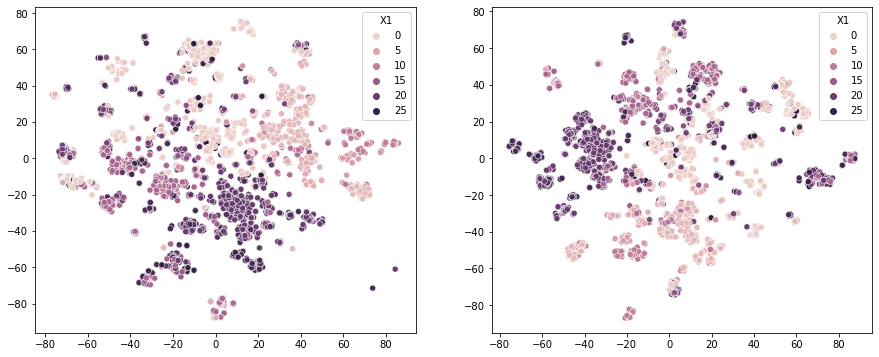

In [48]:
# TSNE on df_scaled and pca_df

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

tsne1 = TSNE (learning_rate=200).fit_transform(df_scaled)
tsne2 = TSNE (learning_rate=200).fit_transform(pca_df)

sns.scatterplot(x=tsne1[:, 0], y=tsne1[:, 1], hue=df_train['X1'], cmap = sns.cubehelix_palette(as_cmap=True), ax=axes[0])
sns.scatterplot(x=tsne2[:, 0], y=tsne2[:, 1], hue=df_train['X1'], cmap = sns.cubehelix_palette(as_cmap=True), ax=axes[1])

<AxesSubplot:>

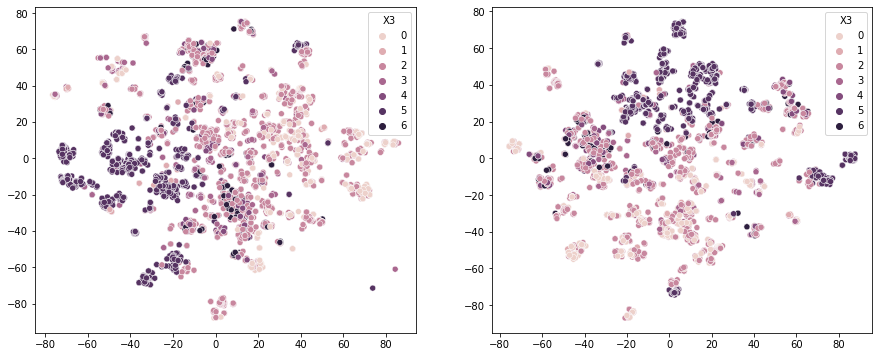

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.scatterplot(x=tsne1[:, 0], y=tsne1[:, 1], hue=df_train['X3'], cmap = sns.cubehelix_palette(as_cmap=True), ax=axes[0])
sns.scatterplot(x=tsne2[:, 0], y=tsne2[:, 1], hue=df_train['X3'], cmap = sns.cubehelix_palette(as_cmap=True), ax=axes[1])

D:\Users\505778\Anaconda3_\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
D:\Users\505778\Anaconda3_\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


<AxesSubplot:>

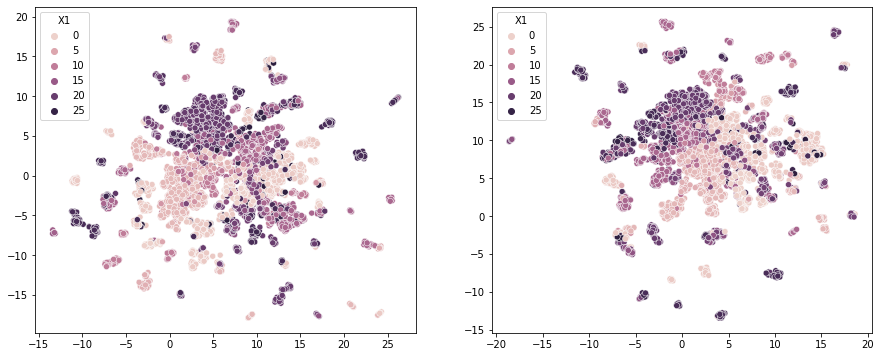

In [50]:
# UMAP on df_scaled and pca_df 
import umap.umap_ as umap
umap1 = umap.UMAP(n_neighbors=20, min_dist=0.9, n_components=2).fit_transform(pca_df)
umap2 = umap.UMAP(n_neighbors=20, min_dist=0.9, n_components=2).fit_transform(df_scaled)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
sns.scatterplot(x=umap1[:, 0], y=umap1[:, 1], hue=df_train['X1'], cmap = sns.cubehelix_palette(as_cmap=True), ax=axes[0])
sns.scatterplot(x=umap2[:, 0], y=umap2[:, 1], hue=df_train['X1'], cmap = sns.cubehelix_palette(as_cmap=True), ax=axes[1])

<AxesSubplot:>

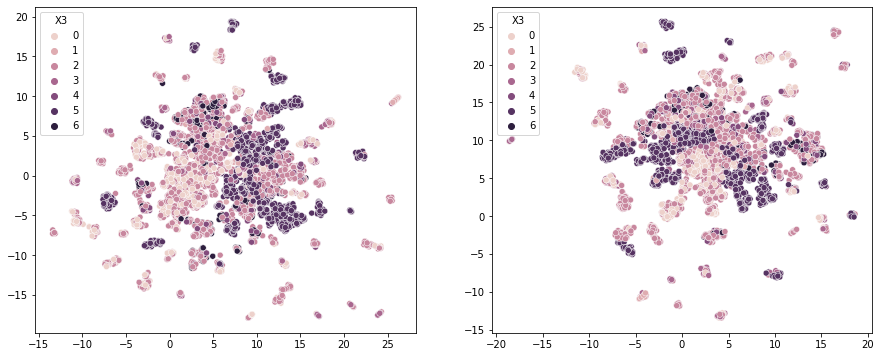

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
sns.scatterplot(x=umap1[:, 0], y=umap1[:, 1], hue=df_train['X3'], cmap = sns.cubehelix_palette(as_cmap=True), ax=axes[0])
sns.scatterplot(x=umap2[:, 0], y=umap2[:, 1], hue=df_train['X3'], cmap = sns.cubehelix_palette(as_cmap=True), ax=axes[1])

### 4. Supervised Learning Model

In [52]:
# Split pca_df, y data
X_train, X_test, y_train, y_test = train_test_split(pca_df,y,test_size=0.3,random_state=42)

In [53]:
# Based on mutiple runs, best parameters : {'pca__n_components': 0.6, 'rf__max_depth': 10.0, 
# 'rf__min_samples_leaf': 5, 'rf__n_estimators': 50}
rf = RandomForestRegressor(max_depth=10,n_estimators=50,min_samples_leaf=10)
rf.fit(X_train,y_train)
print (f"R2 score for train data  : {rf.score(X_train,y_train):2.4f}")
print (f"MSE for train data: {mean_squared_error(y_train,rf.predict(X_train)):2.4f}") 
print (f"RMSE for train data: {np.sqrt(mean_squared_error(y_train,rf.predict(X_train))):2.4f}") 

R2 score for train data  : 0.7062
MSE for train data: 44.0162
RMSE for train data: 6.6345


In [54]:
print (f"R2 score for test data  : {rf.score(X_test,y_test):2.4f}")
print (f"MSE for test data: {mean_squared_error(y_test,rf.predict(X_test)):2.4f}") 
print (f"RMSE for test data: {np.sqrt(mean_squared_error(y_test,rf.predict(X_test))):2.4f}") 

R2 score for test data  : 0.4916
MSE for test data: 84.6683
RMSE for test data: 9.2015


### 5. Using Pipeline

In [55]:
# Split X, y data (df_train after cleaning and normalizing)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [56]:
#rf_param_grid = {
#    'pca__n_components': [0.5, 0.6, 0.7, 0.8, 0.9],
#    'rf__max_depth': [10],
#    'rf__n_estimators': [50],
#    'rf__min_samples_leaf': [5]}

rf_param_grid = {
    'pca__n_components': [0.5, 0.6, 0.7, 0.8, 0.9],
    'rf__max_depth': np.linspace(5,15,3),
    'rf__n_estimators': [50,100],
    'rf__min_samples_leaf': np.linspace(5,15,3, dtype=int)}

rf_pipeline = Pipeline([('scaler', StandardScaler()),
                          ('pca', PCA()),
                          ('rf', RandomForestRegressor())])

rf_grid =GridSearchCV(rf_pipeline, rf_param_grid, cv=5, return_train_score = True)
    
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'pca__n_components': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'rf__max_depth': array([ 5., 10., 15.]),
                         'rf__min_samples_leaf': array([ 5, 10, 15]),
                         'rf__n_estimators': [50, 100]},
             return_train_score=True)

In [57]:
print (f"Best score : {rf_grid.best_score_:2.4f}")
print (f"Best parameters : {rf_grid.best_params_}")

Best score : 0.5321
Best parameters : {'pca__n_components': 0.7, 'rf__max_depth': 10.0, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 100}


In [58]:
params = ((rf_grid.cv_results_['param_rf__max_depth']== rf_grid.best_params_['rf__max_depth']) & (rf_grid.cv_results_['param_rf__min_samples_leaf']== rf_grid.best_params_['rf__min_samples_leaf'])  & (rf_grid.cv_results_['param_rf__n_estimators']== rf_grid.best_params_['rf__n_estimators'])) 
pca_ = rf_grid.cv_results_['param_pca__n_components'][params]
train_score = rf_grid.cv_results_["mean_train_score"][params]
test_score = rf_grid.cv_results_["mean_test_score"][params]
pd.DataFrame({'pca': pca_,'train score': train_score, 'test score': test_score})

,pca,train score,test score
0,0.5,0.742250,0.527310
1,0.6,0.756788,0.531658
2,0.7,0.765074,0.532111
3,0.8,0.770712,0.530136
4,0.9,0.776929,0.524255


In [59]:
rf_estimator = rf_grid.best_estimator_
print (f"Test data score : {rf_estimator.score(X_test, y_test):2.4f}")

Test data score : 0.4931


<AxesSubplot:>

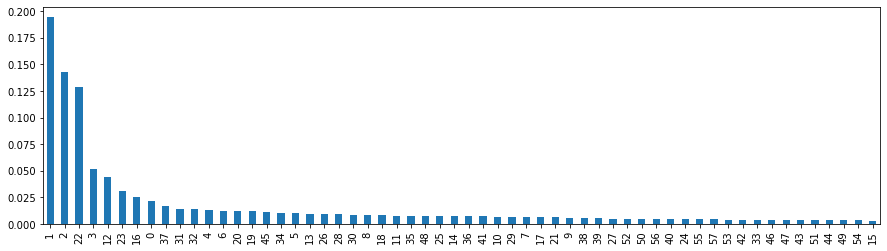

In [60]:
data = pd.Series(rf_estimator[2].feature_importances_)
data.sort_values(ascending=False).plot.bar(figsize=(15,4))

### 6. Conclusion

1. Data cleaning is crucial : I did mutiple runs and every time I had different understanding of the data which resulted adding more code to the cleaning section.
2. Based on the pipeline model, adding more components with very little explained variance ratio to the PCA added minimum improvement to the accuracy to the model. 